# Dimensionality Reduction

## The Curse of Dimensionality
Many Machine Learning problems involve thousands or even millions of features for each training instance. Not only do all these features make training extremely slow, but they can also make it much harder to find a good solution, as we will see. This problem is often referred to as the curse of dimensionality.

In theory, one solution to the curse of dimensionality could be to increase the size of the training set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions. With just 100 features (significantly fewer than in the MNIST problem), you would need more training instances than atoms in the observable universe in order for training instances to be within 0.1 of each other on average, assuming they were spread out uniformly across all dimensions.

## Main Approaches for Dimensionality Reduction
Before we dive into specific dimensionality reduction algorithms, let’s take a look at the two main approaches to reducing dimensionality: projection and Manifold Learning.

### Projection
In most real-world problems, training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated. As a result, all training instances lie within (or close to) a much lower-dimensional subspace of the high-dimensional space. 

If that's the case, we can simply project the datapoints from this dimension to lower ones. However, projection is not always the best approach to dimensionality reduction. In many cases the subspace may twist and turn, such as in the famous Swiss roll toy dataset.

### Manifold Learning
The Swiss roll is an example of a 2D manifold. Put simply, a 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space. More generally, a d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane. In the case of the Swiss roll, d = 2 and n = 3: it locally resembles a 2D plane, but it is rolled in the third dimension.

Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called Manifold Learning. It relies on the manifold assumption, also called the manifold hypothesis, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. This assumption is very often empirically observed.



## Principal Component Analysis (PCA)
Principal Component Analysis (PCA) is by far the most popular dimensionality reduc‐ tion algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

### Preserving the Variance
Before you can project the training set onto a lower-dimensional hyperplane, you first need to choose the right hyperplane. It is reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. Another way to justify this choice is that it is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis. This is the rather simple idea behind PCA.

### Principal Components
PCA identifies the axis that accounts for the largest amount of variance in the training set. It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of remaining variance. In this 2D example there is no choice: it is the dotted line. If it were a higher-dimensional dataset, PCA would also find a third axis, orthogonal to both previous axes, and a fourth, a fifth, and so on—as many axes as the number of dimensions in the dataset.

NOTE: For each principal component, PCA finds a zero-centered unit vector pointing in the direction of the PC. Since two opposing unit vectors lie on the same axis, the direction of the unit vectors returned by PCA is not stable: if you perturb the training set slightly and run PCA again, the unit vectors may point in the opposite direction as the original vectors. However, they will generally still lie on the same axes. In some cases, a pair of unit vectors may even rotate or swap (if the variances along these two axes are close), but the plane they define will generally remain the same.

So how can you find the principal components of a training set? Luckily, there is a standard matrix factorization technique called ***Singular Value Decomposition (SVD)*** that can decompose the training set matrix $X$ into the matrix multiplication of three matrices $U, Σ, V^T$, where $V$ contains the unit vectors that define all the principal components that we are looking for.

The following Python code uses NumPy’s svd() function to obtain all the principal components of the training set, then extracts the two unit vectors that define the first two PCs:

```Python
import numpy as np
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]
```

NOTE: PCA assumes that the dataset is centered around the origin. Scikit-Learn’s PCA classes take care of centering the data. If you implement PCA yourself (as in the preceding example), or if you use other libraries, don’t forget to center the data first.

### Projecting Down to d Dimensions

Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to d dimensions by projecting it onto the hyperplane defined by the first d principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible.

To project the training set onto the hyperplane and obtain a reduced dataset $X_{d-proj}$ of dimensionality d, compute the matrix multiplication of the training set matrix $X$ by the matrix $W_d$, defined as the matrix containing the first d columns of $V$.

***Projecting the training set down to d dimensions*** <br>
$X_{d-proj} = X W_d$

The following Python code projects the training set onto the plane defined by the first two principal components:
```Python
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
```


### Using Scikit-Learn

Scikit-Learn’s PCA class uses SVD decomposition to implement PCA, just like we did earlier in this chapter. The following code applies PCA to reduce the dimensionality of the dataset down to two dimensions (note that it automatically takes care of centering the data):

```Python
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
```

After fitting the PCA transformer to the dataset, its components_ attribute holds the transpose of Wd (e.g., the unit vector that defines the first principal component is equal to pca.components_.T[:, 0]).

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
print(f"X.shape - {X.shape}")
print(f"y.shape - {y.shape}")

X.shape - (70000, 784)
y.shape - (70000,)


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
print(f"X2D.shape - {X2D.shape}")

X2D.shape - (70000, 2)


### Explained Variance Ratio
Another useful piece of information is the explained variance ratio of each principal component, available via the explained_variance_ratio_ variable. The ratio indicates the proportion of the dataset’s variance that lies along each principal component.

In [ ]:
pca.explained_variance_ratio_

array([0.09746116, 0.07155445])

### Choosing the Right Number of Dimensions

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is simpler to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., 95%). Unless, of course, you are reducing dimensionality for data visualization—in that case you will want to reduce the dimensionality down to 2 or 3.

The following code performs PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set’s variance:


In [ ]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(f"d - {d}")
print(f"pca.explained_variance_ratio_ SUM - {np.sum(pca.explained_variance_ratio_)}")

d - 154
pca.explained_variance_ratio_ SUM - 1.0000000000000002


You could then set **n_components=d** and run PCA again. But there is a much better option: instead of specifying the number of principal components you want to preserve, you can set n_components to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve:


In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
print(f"pca.explained_variance_ratio_ SUM - {np.sum(pca.explained_variance_ratio_)}")

pca.explained_variance_ratio_ SUM - 0.9503499702078614


Yet another option is to plot the explained variance as a function of the number of dimensions (simply plot cumsum). There will usually be an elbow in the curve, where the explained variance stops growing fast. 

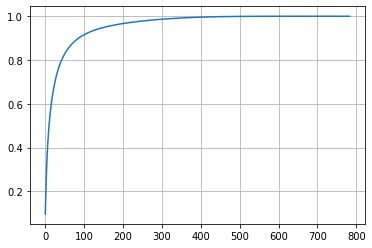

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cumsum)
plt.grid()

### PCA for Compression

After dimensionality reduction, the training set takes up much less space. As an example, try applying PCA to the MNIST dataset while preserving 95% of its variance. You should find that each instance will have just over 150 features, instead of the original 784 features. So, while most of the variance is preserved, the dataset is now less than 20% of its original size! This is a reasonable compression ratio, and you can see how this size reduction can speed up a classification algorithm (such as an SVM classifier) tremendously.

It is also possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection. This won’t give you back the original data, since the projection lost a bit of information (within the 5% var‐ iance that was dropped), but it will likely be close to the original data. The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the reconstruction error.

Let's have a look.

In [ ]:
X_recovered = pca.inverse_transform(X_reduced)
print(f"X_recovered.shape - {X_recovered.shape}")

X_recovered.shape - (70000, 784)


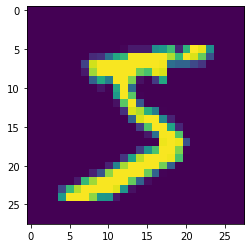

In [ ]:
# plot original data
plt.imshow(X[0].reshape((28, -1)))

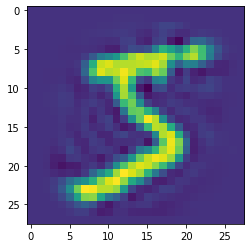

In [ ]:
# plot recovered data
plt.imshow(X_recovered[0].reshape((28, -1)))

### Randomized PCA
If you set the **svd_solver** hyperparameter to "randomized", Scikit-Learn uses a stochastic algorithm called Randomized PCA that quickly finds an approximation of the first d principal components. Its computational complexity is $O(m × d^2) + O(d^3)$, instead of $O(m × n^2) + O(n^3)$ for the full SVD approach, so it is dramatically faster than full SVD when d is much smaller than n:

In [ ]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X)
print(f"X_reduced.shape - {X_reduced.shape}")

X_reduced.shape - (70000, 154)


By default, svd_solver is actually set to "auto": Scikit-Learn automatically uses the randomized PCA algorithm if m or n is greater than 500 and d is less than 80% of m or n, or else it uses the full SVD approach. If you want to force Scikit-Learn to use full SVD, you can set the svd_solver hyperparameter to "full".

### Incremental PCA
One problem with the preceding implementations of PCA is that they require the whole training set to fit in memory in order for the algorithm to run. Fortunately, Incremental PCA (IPCA) algorithms have been developed. They allow you to split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time. This is useful for large training sets and for applying PCA online (i.e., on the fly, as new instances arrive). 

The following code splits the MNIST dataset into 100 mini-batches (using NumPy’s array_split() function) and feeds them to Scikit-Learn’s IncrementalPCA class5 to reduce the dimensionality of the MNIST dataset down to 154 dimensions (just like before). Note that you must call the partial_fit() method with each mini-batch, rather than the fit() method with the whole training set:


In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X, n_batches):
    inc_pca.partial_fit(X_batch)
    X_reduced = inc_pca.transform(X)
print(f"X_reduced.shape - {X_reduced.shape}")

X_reduced.shape - (70000, 154)


Alternatively, you can use NumPy’s *memmap* class, which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory; the class loads only the data it needs in memory, when it needs it. Since the IncrementalPCA class uses only a small part of the array at any given time, the memory usage remains under control. This makes it possible to call the usual fit() method, as you can see in the following code:
```Python
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)
```

## Kernel PCA

A mathematical technique that implicitly maps instances into a very high-dimensional space (called the feature space), enabling nonlinear classification and regression with Support Vector Machines. A linear decision boundary in the high-dimensional feature space corresponds to a complex nonlinear decision boundary in the original space.

It turns out that the same trick can be applied to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction. This is called Kernel PCA (kPCA). It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold.

The following code uses Scikit-Learn’s KernelPCA class to perform kPCA with an RBF kernel.
```Python
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)
print(f"X_reduced.shape - {X_reduced.shape}")  
```


### Selecting a Kernel and Tuning Hyperparameters
As kPCA is an unsupervised learning algorithm, there is no obvious performance measure to help you select the best kernel and hyperparameter values. That said, dimensionality reduction is often a preparation step for a supervised learning task (e.g., classification), so you can use grid search to select the kernel and hyperparameters that lead to the best performance on that task. The following code creates a twostep pipeline, first reducing dimensionality to two dimensions using kPCA, then applying Logistic Regression for classification. Then it uses GridSearchCV to find the best kernel and gamma value for kPCA in order to get the best classification accuracy at the end of the pipeline:

```Python 
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])
param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

print(grid_search.best_params_)
```

## t-distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples. See [docs](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

```Python
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
print(f"X_tsne.shape - {X_tsne.shape}")
```

## Linear Discriminant Analysis (LDA)

A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule. See [docs](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html).

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)
print(f"X_lda.shape - {X_lda.shape}")

X_lda.shape - (70000, 9)
